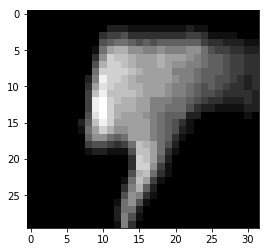

In [7]:
# test pgm reading
import re
import numpy as np

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


filename='./gestures/A/A_down_2.pgm'

if __name__ == "__main__":
    from matplotlib import pyplot
    image = read_pgm(filename, byteorder='<')
#     print type(image), image
#     pyplot.imshow(image, pyplot.cm.gray)
#     pyplot.show()
    
    image = image.astype('float32')
    image /= np.max(image)
#     print image
    pyplot.imshow(image, pyplot.cm.gray)
    pyplot.show()

In [8]:
def __sigmoid(x):
    if x>=30.0: 
        return 1.0
    elif x<=-30.0:
        return 0.0
    else:
        return 1.0 / (1.0 + np.exp(-x))

def __sigmoid_derivative(x):
    return x * (1 - x)

def sigmoid(x):
    vfunc = np.vectorize(__sigmoid)
    return vfunc(x)

def sigmoid_derivative(x):
    vfunc = np.vectorize(__sigmoid_derivative)
    return vfunc(x)

class NeuralNetwork:
    def __init__(self, input_n, hidden_n, output_n):
        self.input_n = input_n + 1
        self.hidden_n = hidden_n
        self.output_n = output_n
        self.input_layer = np.ones((1,self.input_n))
        # init weights
        self.input_weights=np.random.uniform(-0.01,0.01,(self.input_n,self.hidden_n))
        self.output_weights=np.random.uniform(-0.01,0.01,(self.hidden_n,self.output_n))

    def predict(self, x_train):
        # activate input layer
        for j in range(x_train.shape[0]):
            self.input_layer[:,j]=x_train[j]
        # activate hidden layer
        self.hidden_cells=sigmoid(np.dot(self.input_layer,self.input_weights))
        # activate output layer
        self.output_cells=np.round(sigmoid(np.dot(self.hidden_cells,self.output_weights)))
        return self.output_cells

    def back_propagate(self, x_train, y_train, learn):
        # feed forward
        self.predict(x_train)
        # get output layer error
        output_deltas=y_train-self.output_cells
        # get hidden layer error
        hidden_deltas=np.dot(output_deltas,self.output_weights.T)*sigmoid_derivative(self.hidden_cells)
        # update output weights
        delta=np.dot(self.hidden_cells.T,output_deltas)
        self.output_weights+=learn*delta
        # update input weights
        delta=np.dot(self.input_layer.T,hidden_deltas)
        self.input_weights+=learn*delta
        # get global error
        # error=(y_train*self.output_cells)**2/len(y_train)
        # return np.sum(error)

    def train(self, x_train, y_train, limit=10000, learn=0.05):
        for j in range(limit):
            for i in range(len(x_train)):
                self.back_propagate(x_train[i], y_train[i], learn)
            if np.sum(np.abs(y_train-self.test(x_train)))<1.0:
                print("Converge after " + str(j) + " epoch(s).")
                return
        print "After " + str(j) + " epoch(s)"

    def test(self, x_test):
        y_pred = []
        for case in x_test:
            y_pred.append([np.squeeze(self.predict(case))])
        return np.array(y_pred)

In [9]:
# get training data
train_filelist = 'downgesture_train.list'
x_train=[]
y_train=[]
with open(train_filelist, 'r') as train_fl:
    for train_fn in train_fl.readlines():
        
        image = read_pgm(train_fn[:-1], byteorder='<')
        image = image.astype('float32')
        image /= np.max(image)
        
        x_train.append(np.squeeze(image.reshape(1,-1)))
        
        y_train.append([0. if re.match(string=train_fn, pattern='.*?down.*?')==None else 1.])
        
x_train = np.array(x_train)
y_train = np.array(y_train)

print len(y_train), y_train.T

184 [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
# get testing data
test_filelist = 'downgesture_test.list'
x_test=[]
y_test=[]
with open(test_filelist, 'r') as test_fl:
    for test_fn in test_fl.readlines():
        
        image = read_pgm(test_fn[:-1], byteorder='<')
        image = image.astype('float32')
        image /= np.max(image)
        
        x_test.append(np.squeeze(image.reshape(1,-1)))
        
        y_test.append([0. if re.match(string=test_fn, pattern='.*?down.*?')==None else 1.])
        
x_test = np.array(x_test)
y_test = np.array(y_test)
print len(y_test), y_test.T

83 [[1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
from time import time
# neural network training
NN=NeuralNetwork(x_train.shape[1], 25, y_train.shape[1])  

train_start_time = time()
NN.train(x_train, y_train,limit=1000, learn=0.1)
print 'Time elapsed during training: %.3fs' % (time()-train_start_time)
y_pred = np.abs(np.round(NN.test(x_train)))
# print y_pred.T
print 'Training accuracy:',1.0-np.sum(np.abs(y_pred-y_train))/len(y_pred)

Converge after 363 epoch(s).
Time elapsed during training: 89.043s
Training accuracy: 1.0


In [12]:
# neural network testing
y_pred = np.abs(np.round(NN.test(x_test)))
# print y_pred.T
print 'testing accuracy:',1.0-np.sum(np.abs(y_pred-y_test))/len(y_pred)

testing accuracy: 0.8192771084337349
